In [0]:
# importa as bibliotecas necessárias
from pyspark.sql.functions import col, to_date
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DateType, FloatType


In [0]:
# Cria um DataFrame com o conteúdo do arquivo csv (bronze)
df_bronze = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/Capacidade_Geracao.csv")

In [0]:
#Tratamento dos dados (camada silver)
spark = SparkSession.builder.appName("ManipularDataFrame").getOrCreate()
selected_columns = ["_id", "id_estado", "nom_tipousina", "nom_usina", "ceg", "cod_equipamento", "nom_combustivel", "dat_entradaoperacao", "dat_desativacao", "val_potenciaefetiva"]
df_silver = df_bronze.select(selected_columns)

# Converter as colunas "dat_entradaoperacao" e "dat_desativacao" para o formato data
df_silver = df_silver.withColumn("dat_entradaoperacao", to_date(col("dat_entradaoperacao"), "yyyy-MM-dd'T'HH:mm:ss")) \
                          .withColumn("dat_desativacao", to_date(col("dat_desativacao"), "yyyy-MM-dd'T'HH:mm:ss"))

# Converter a coluna "val_potenciaefetiva" para float e a coluna "_id" para integer
df_silver = df_silver.withColumn("val_potenciaefetiva", col("val_potenciaefetiva").cast("float")) \
                        .withColumn("_id",col("_id").cast("integer"))

# Definir o novo esquema com nullable = false as colunas que devem ter essa característica
new_schema = StructType([
    StructField("_id", IntegerType(), nullable=False),
    StructField("id_estado", StringType(), nullable=False),
    StructField("nom_tipousina", StringType(), nullable=False),
    StructField("nom_usina", StringType(), nullable=False),
    StructField("ceg", StringType(), nullable=False),
    StructField("cod_equipamento", StringType(), nullable=False),
    StructField("nom_combustivel", StringType(), nullable=False),
    StructField("dat_entradaoperacao", DateType(), nullable=False),
    StructField("dat_desativacao", DateType(), nullable=True),
    StructField("val_potenciaefetiva", FloatType(), nullable=False)
])

# Aplicar o novo esquema ao DataFrame
df_silver = spark.createDataFrame(df_silver.rdd, schema=new_schema)

# Exibir o esquema do novo DataFrame para verificar as alterações
df_silver.printSchema()



root
 |-- _id: integer (nullable = false)
 |-- id_estado: string (nullable = false)
 |-- nom_tipousina: string (nullable = false)
 |-- nom_usina: string (nullable = false)
 |-- ceg: string (nullable = false)
 |-- cod_equipamento: string (nullable = false)
 |-- nom_combustivel: string (nullable = false)
 |-- dat_entradaoperacao: date (nullable = false)
 |-- dat_desativacao: date (nullable = true)
 |-- val_potenciaefetiva: float (nullable = false)



In [0]:
# Verifica se a coluna "id_estado" possui algum valor inválido. Os valores válidos são as siglas dos 27 estados da federação, além de "I" que representa o Paraguai em sua parcela de Itaipu

siglas_estados = ["AC", "AL", "AP", "AM", "BA", "CE", "DF", "ES", "GO", "MA", "MT", "MS", "MG", "PA", "PB", "PR", "PE", "PI", "RJ", "RN", "RS", "RO", "RR", "SC", "SP", "SE", "TO", "I"]

valores_invalidos = df_silver.filter(~df_silver["id_estado"].isin(siglas_estados))
contagem_invalidos = valores_invalidos.count()
print(f"Número de valores inválidos na coluna 'id_estado': {contagem_invalidos}")
if contagem_invalidos >0:
    valores_invalidos.show()



Número de valores inválidos na coluna 'id_estado': 0


In [0]:
# Verifica se há valores inválidos na coluna "val_potenciaefetiva". Os valores devem ser numéricos e positivos
valores_invalidos_potencia = df_silver.filter((col("val_potenciaefetiva") <= 0) | (col("val_potenciaefetiva").isNull()))

contagem_invalidos_potencia = valores_invalidos_potencia.count()
print(f"Número de valores inválidos na coluna 'val_potenciaefetiva': {contagem_invalidos_potencia}")
if contagem_invalidos_potencia >0:
    valores_invalidos_potencia.show()



Número de valores inválidos na coluna 'val_potenciaefetiva': 0


In [0]:
# Verifica se há algum valor nula nas colunas que não dever ter valores nulos
colunas_nao_nulas = ["_id", "id_estado", "nom_tipousina", "nom_usina", "ceg", "cod_equipamento", "nom_combustivel", "dat_entradaoperacao", "val_potenciaefetiva"]

# Filtra as linhas que possuem valores nulos em alguma das colunas não nulas
valores_nulos = df_silver.filter(
    sum(col(coluna).isNull().cast("int") for coluna in colunas_nao_nulas) > 0
)

# Contagem dos valores nulos
contagem_nulos = valores_nulos.count()
print(f"Número de valores nulos nas colunas não nulas: {contagem_nulos}")

# Exibindo os valores nulos apenas se a contagem for maior que zero
if contagem_nulos > 0:
    valores_nulos.show()


Número de valores nulos nas colunas não nulas: 0


In [0]:
# Criar tabela silver
df_silver.write.format("delta").mode("overwrite").saveAsTable("tabela_silver")


In [0]:
# Criar a camada gold
df_gold = df_silver.filter(df_silver["dat_desativacao"].isNull())
df_gold.write.format("delta").mode("overwrite").saveAsTable("tabela_gold")


In [0]:
# Verificar número de linhas dos Dataframes
num_linhas_silver = df_silver.count()
num_linhas_gold = df_gold.count()

print(f"O DataFrame silver contém {num_linhas_silver} linhas.")
print(f"O DataFrame gold contém {num_linhas_gold} linhas.")

O DataFrame silver contém 4987 linhas.
O DataFrame gold contém 4020 linhas.


In [0]:
%sql
UPDATE tabela_gold
SET nom_tipousina = 'EÓLICA'
WHERE nom_tipousina = 'EOLIELÉTRICA';

num_affected_rows
1952


Solução dos problemas

1.	Qual o percentual de participação de cada fonte de geração na matriz elétrica brasileira atualmente?

In [0]:
%sql
SELECT nom_tipousina,
ROUND(SUM(val_potenciaefetiva),1) AS soma_potencia,
ROUND((SUM(val_potenciaefetiva) / (SELECT SUM(val_potenciaefetiva) FROM tabela_gold) * 100),1) AS percentual_participacao
FROM tabela_gold
GROUP BY nom_tipousina
ORDER BY percentual_participacao DESC;

nom_tipousina,soma_potencia,percentual_participacao
HIDROELÉTRICA,109603.1,59.4
TÉRMICA,30170.4,16.3
EÓLICA,29704.0,16.1
FOTOVOLTAICA,13179.0,7.1
NUCLEAR,1990.0,1.1


2.	Qual o montante de capacidade adicionada no ano de 2023, segregado por fonte?

In [0]:
%sql
SELECT nom_tipousina,
ROUND(SUM(val_potenciaefetiva),1) AS capacidade_adicionada_2023
FROM tabela_gold
WHERE YEAR (dat_entradaoperacao) = 2023
GROUP BY nom_tipousina
ORDER BY capacidade_adicionada_2023 DESC

nom_tipousina,capacidade_adicionada_2023
EÓLICA,4848.2
FOTOVOLTAICA,4045.8
TÉRMICA,834.1
HIDROELÉTRICA,22.3


3.	Listar as usinas desativadas no ano de 2023.

In [0]:
%sql
SELECT 
    ceg, 
    nom_usina, 
    nom_tipousina, 
    ROUND(SUM(val_potenciaefetiva), 1) AS potencia
FROM 
    tabela_silver
WHERE 
    YEAR(dat_desativacao) = 2023
GROUP BY 
    ceg,
    nom_usina,
    nom_tipousina,
    dat_desativacao
ORDER BY 
    dat_desativacao DESC


ceg,nom_usina,nom_tipousina,potencia
UTE.GN.CE.028357-6.01,FORTALEZA,TÉRMICA,326.6
UTE.FL.SP.035103-2.01,PREDILECTA,TÉRMICA,5.0
UFV.RS.PE.040725-9.01,BELMONTE 1-1,FOTOVOLTAICA,50.0


4.	Quais os 3 estados da federação com a maior capacidade de geração instalada da fonte solar? 

In [0]:
%sql
SELECT id_estado AS UF,
ROUND(SUM(val_potenciaefetiva),1) AS potencia
FROM tabela_gold
WHERE nom_tipousina = "FOTOVOLTAICA"
GROUP BY UF
ORDER BY potencia DESC
LIMIT 3

UF,potencia
MG,4419.4
PI,2031.4
BA,1969.0


5.	Quais os 3 estados da federação com a maior capacidade de geração instalada da fonte eólica?

In [0]:
%sql
SELECT id_estado AS UF,
ROUND(SUM(val_potenciaefetiva),1) AS potencia
FROM tabela_gold
WHERE nom_tipousina = "EÓLICA"
GROUP BY UF
ORDER BY potencia DESC
LIMIT 3

UF,potencia
RN,9744.4
BA,9472.0
PI,3921.8


6. Comparar a matriz elétrica atual com os anos de 2000, 2010 e 2020.

In [0]:
%sql
SELECT 
    CASE 
        WHEN nom_tipousina = 'BOMBEAMENTO' THEN 'HIDROELÉTRICA'
        WHEN nom_tipousina = 'EOLIELÉTRICA' THEN 'EÓLICA'
        ELSE nom_tipousina
    END AS nom_tipousina,
    ROUND(SUM(CASE WHEN YEAR(dat_entradaoperacao) <= 2000 AND (dat_desativacao IS NULL OR YEAR(dat_desativacao) > 2000) THEN val_potenciaefetiva ELSE 0 END), 1) AS potencia_2000,
    ROUND(SUM(CASE WHEN YEAR(dat_entradaoperacao) <= 2010 AND (dat_desativacao IS NULL OR YEAR(dat_desativacao) > 2010) THEN val_potenciaefetiva ELSE 0 END), 1) AS potencia_2010,
    ROUND(SUM(CASE WHEN YEAR(dat_entradaoperacao) <= 2020 AND (dat_desativacao IS NULL OR YEAR(dat_desativacao) > 2020) THEN val_potenciaefetiva ELSE 0 END), 1) AS potencia_2020,
    ROUND(SUM(CASE WHEN YEAR(dat_entradaoperacao) <= 2024 AND (dat_desativacao IS NULL OR YEAR(dat_desativacao) > 2024) THEN val_potenciaefetiva ELSE 0 END), 1) AS potencia_2024
FROM 
    tabela_silver
GROUP BY 
    CASE 
        WHEN nom_tipousina = 'BOMBEAMENTO' THEN 'HIDROELÉTRICA'
        WHEN nom_tipousina = 'EOLIELÉTRICA' THEN 'EÓLICA'
        ELSE nom_tipousina
    END
ORDER BY 
    nom_tipousina;




nom_tipousina,potencia_2000,potencia_2010,potencia_2020,potencia_2024
EÓLICA,0.0,567.8,16058.5,29704.0
FOTOVOLTAICA,0.0,0.0,2879.0,13179.0
HIDROELÉTRICA,65234.1,83347.8,109444.4,109603.1
NUCLEAR,640.0,1990.0,1990.0,1990.0
TÉRMICA,4925.9,17143.9,27322.7,30170.4


In [0]:
# Executar a consulta SQL e obter os resultados em um DataFrame do Spark
df_spark = spark.sql("""
SELECT 
    CASE 
        WHEN nom_tipousina = 'BOMBEAMENTO' THEN 'HIDROELÉTRICA'
        WHEN nom_tipousina = 'EOLIELÉTRICA' THEN 'EÓLICA'
        ELSE nom_tipousina
    END AS nom_tipousina,
    SUM(CASE WHEN YEAR(dat_entradaoperacao) <= 2000 AND (dat_desativacao IS NULL OR YEAR(dat_desativacao) > 2000) THEN val_potenciaefetiva ELSE 0 END) AS potencia_2000,
    SUM(CASE WHEN YEAR(dat_entradaoperacao) <= 2010 AND (dat_desativacao IS NULL OR YEAR(dat_desativacao) > 2010) THEN val_potenciaefetiva ELSE 0 END) AS potencia_2010,
    SUM(CASE WHEN YEAR(dat_entradaoperacao) <= 2020 AND (dat_desativacao IS NULL OR YEAR(dat_desativacao) > 2020) THEN val_potenciaefetiva ELSE 0 END) AS potencia_2020,
    SUM(CASE WHEN YEAR(dat_entradaoperacao) <= 2024 AND (dat_desativacao IS NULL OR YEAR(dat_desativacao) > 2024) THEN val_potenciaefetiva ELSE 0 END) AS potencia_2024
FROM tabela_silver
GROUP BY 
    CASE 
        WHEN nom_tipousina = 'BOMBEAMENTO' THEN 'HIDROELÉTRICA'
        WHEN nom_tipousina = 'EOLIELÉTRICA' THEN 'EÓLICA'
        ELSE nom_tipousina
    END
""")

# Converter o DataFrame do Spark para um DataFrame do Pandas
df_pandas = df_spark.toPandas()


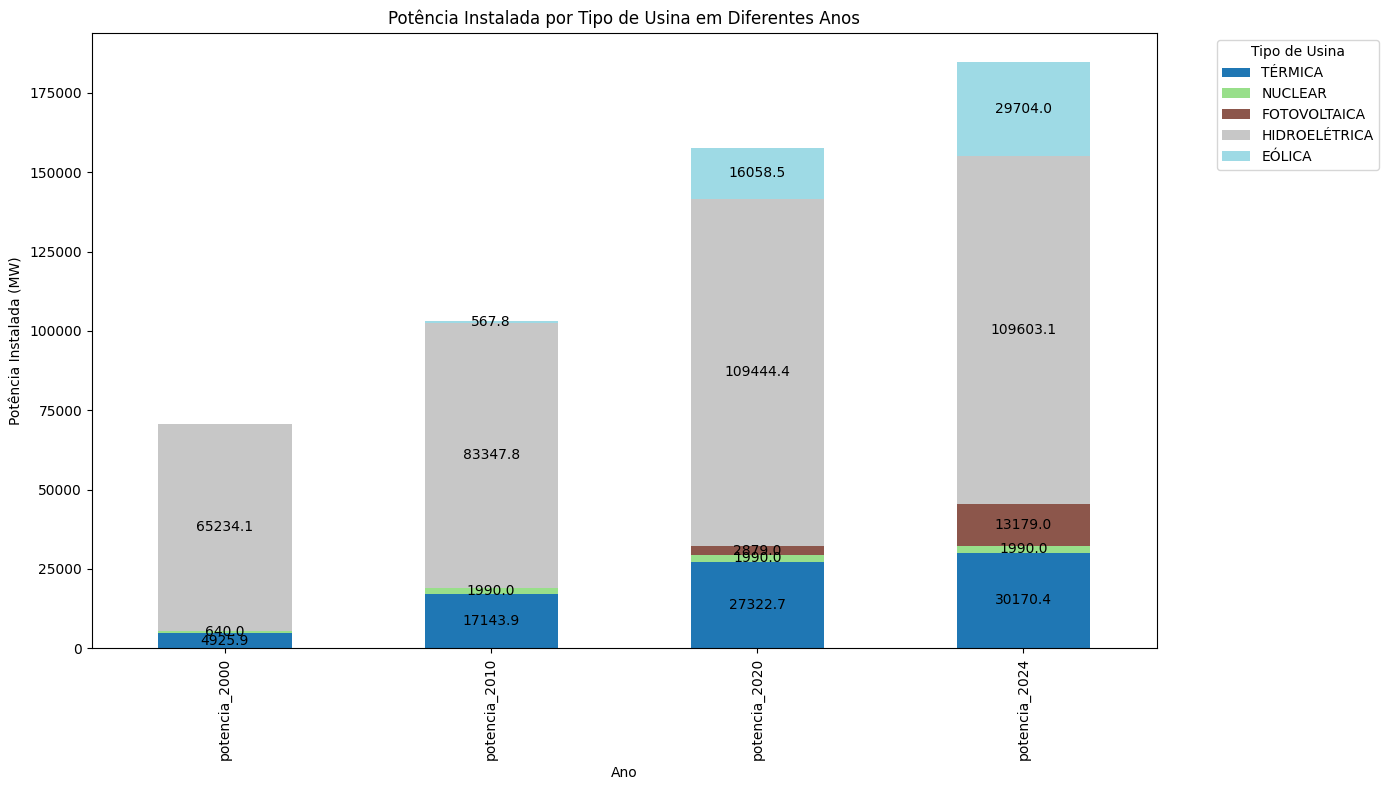

In [0]:
import matplotlib.pyplot as plt

# Configurar os dados
years = ['2000', '2010', '2020', '2024']
df_pandas.set_index('nom_tipousina', inplace=True)
df_pandas = df_pandas.T

# Criar o gráfico
ax = df_pandas.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')

# Adicionar rótulos e título
ax.set_xlabel('Ano')
ax.set_ylabel('Potência Instalada (MW)')
ax.set_title('Potência Instalada por Tipo de Usina em Diferentes Anos')
ax.legend(title='Tipo de Usina', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adicionar os valores acima das barras
def add_values(bars):
    for bar in bars:
        for rect in bar:
            height = rect.get_height()
            if height > 0:
                ax.annotate(f'{height:.1f}',
                            xy=(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2),
                            xytext=(0, 0),
                            textcoords="offset points",
                            ha='center', va='center')

# Chamar a função para cada pilha de barras
bars = [rects for rects in ax.containers]
add_values(bars)

# Ajustar layout
plt.tight_layout()

# Mostrar o gráfico
plt.show()
